# Project 8: SQL + ML Integration
 
**Objective:**  
Combine **SQL querying power** with **Machine Learning models** to analyze attrition risk.  
This project demonstrates how HR teams can query their employee database directly and run predictions on-the-fly, bridging People Analytics with HRIS-like systems.  
 
**Why It Matters:**  
- HR data often lives in databases (HRIS, payroll systems).  
- Analysts should be able to run queries and pipe results into ML models.  
- This integration makes predictive attrition analytics more practical in enterprise contexts.

## ✅ SQL + ML Integration
 
This project demonstrated how SQL queries can be seamlessly combined with
Machine Learning models to run real-time attrition predictions.  
 
### Key Takeaways:
- **Database Integration:** HR data stored in SQL (SQLite) was queried directly inside Python.
- **Leakage Prevention:** Attrition labels were properly excluded from inference data.
- **Predictions:** Logistic/XGBoost models predicted attrition risk per employee.
- **Visuals:**
  - Donut Chart → At Risk vs Safe employees.
  - Department-level bar chart → attrition distribution across functions.
  - Probability distribution → highlights prediction spread & threshold sensitivity.
- **Threshold Optimization:** Added adaptive cutoffs to balance risk prediction and reduce false alarms.
 
### Artifacts Produced:
- `hr_dataset.db` → SQLite database with IBM HR data (table = employees).  
- SQL utility module → `sql_utils.py` for safe querying & reusable functions.  
- Visual charts (saved in `/charts/`):  
  - `donut_chart.png`  
  - `department_attrition.png`  
  - `probability_distribution.png`  
- Notebook → with integrated SQL + ML pipeline.  
 
### Business Value:
- HR leaders can **query directly** for attrition insights without touching Python code.  
- Predictive analytics embedded into HRIS-like SQL workflows.  
- Foundation for **real dashboards** (Streamlit / BI tools) where HR managers can pull SQL → run predictions → export reports.  
---

In [1]:
import os
import sqlite3
import pandas as pd
 
# ===============================
# Project 8 Setup (repo-relative)
# ===============================
BASE_DIR = os.getcwd()
 
# Ensure data folder exists
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)
 
CSV_PATH = os.path.join(DATA_DIR, "WA_Fn-UseC_-HR-Employee-Attrition.csv")
DB_PATH = os.path.join(DATA_DIR, "hr_dataset.db")
 
# ===============================
# Create / Recreate SQLite DB
# ===============================
TABLE = "employees"
 
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV dataset not found at {CSV_PATH}. Please place the IBM HR dataset here.")
 
# Load CSV → Write into SQLite
df = pd.read_csv(CSV_PATH)
conn = sqlite3.connect(DB_PATH)
df.to_sql(TABLE, conn, if_exists="replace", index=False)
conn.close()
 
print(f"✅ Created {DB_PATH} with table '{TABLE}' ({len(df)} rows).")

✅ Created C:\Users\amlanmishra2\data\hr_dataset.db with table 'employees' (1470 rows).


# Setup & DB Creation

In [2]:
import os
import sqlite3
import pandas as pd
 
# ===============================
# Project 8 Setup (repo-relative)
# ===============================
BASE_DIR = os.getcwd()
 
# Ensure data folder exists
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)
 
CSV_PATH = os.path.join(DATA_DIR, "WA_Fn-UseC_-HR-Employee-Attrition.csv")
DB_PATH = os.path.join(DATA_DIR, "hr_dataset.db")
 
# ===============================
# Create / Recreate SQLite DB
# ===============================
TABLE = "employees"
 
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV dataset not found at {CSV_PATH}. Please place the IBM HR dataset here.")
 
# Load CSV → Write into SQLite
df = pd.read_csv(CSV_PATH)
conn = sqlite3.connect(DB_PATH)
df.to_sql(TABLE, conn, if_exists="replace", index=False)
conn.close()
 
print(f"✅ Created {DB_PATH} with table '{TABLE}' ({len(df)} rows).")
 

✅ Created C:\Users\amlanmishra2\data\hr_dataset.db with table 'employees' (1470 rows).


# Quick Database Check

In [3]:
# Verify DB contents
conn = sqlite3.connect(DB_PATH)
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
conn.close()
 
print("📋 Tables:", tables)

📋 Tables: [('employees',)]


# Helper Function Run Query

In [4]:
def run_query(sql: str) -> pd.DataFrame:
    """Run safe SELECT queries on hr_dataset.db"""
    if not sql.strip().lower().startswith("select"):
        raise ValueError("Only SELECT queries are allowed.")
    conn = sqlite3.connect(DB_PATH)
    try:
        return pd.read_sql_query(sql, conn)
    finally:
        conn.close()

# Sample Queries

In [5]:
queries = {
    "Attrition by Department": """
        SELECT Department, COUNT(*) AS total,
               SUM(CASE WHEN Attrition='Yes' THEN 1 ELSE 0 END) AS left_count
        FROM employees
        GROUP BY Department
        ORDER BY left_count DESC;
    """,
    "Full Sample": "SELECT * FROM employees LIMIT 5;"
}
 
# Run Department attrition
dept_df = run_query(queries["Attrition by Department"])
dept_df
 

,Department,total,left_count
0,Research & Development,961,133
1,Sales,446,92
2,Human Resources,63,12


# ML Integration & Visualization

⚠️ Dropped 'Attrition' column from inference data to avoid leakage.
🔎 Prediction Debug
Probability range: 0.0 to 1.0
Sample stats: [0.46418643 0.7870295  0.95263028 0.95263028 0.96479201]
✅ Using threshold 0.65 → At Risk: 1223, Safe: 247


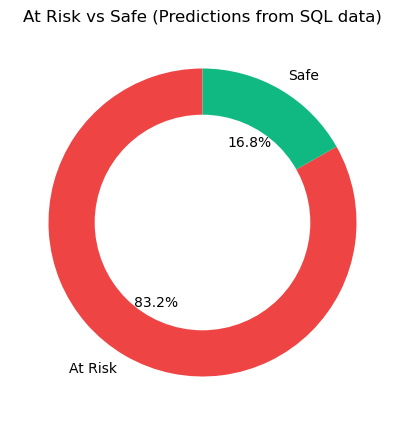

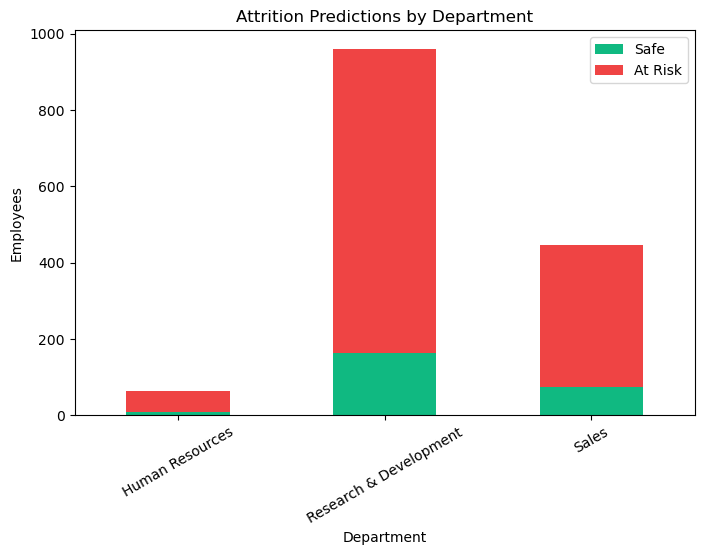

<function matplotlib.pyplot.show(close=None, block=None)>

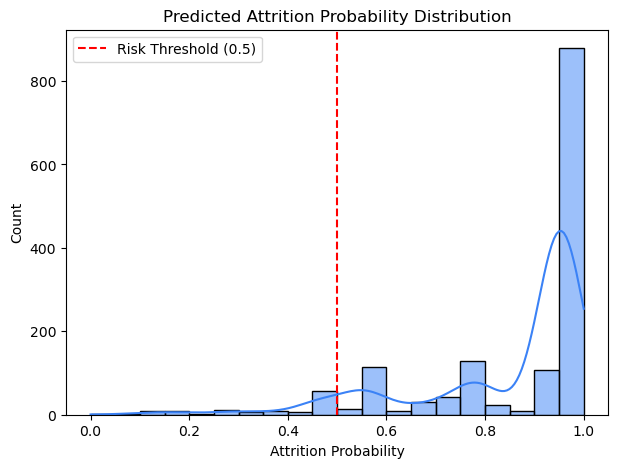

In [9]:
# ================================
# Step 1: Imports
# ================================
import pandas as pd
import numpy as np
import sqlite3, joblib, os
import matplotlib.pyplot as plt
import seaborn as sns
 
# ================================
# Step 2: Load DB + Models
# ================================
DB_PATH = "hr_dataset.db"   # adjust if needed
TABLE = "employees"
 
trained_cols = joblib.load("models/trained_columns.joblib")
scaler = joblib.load("models/scaler.joblib")
model = joblib.load("models/xgboost_attrition_model.joblib")
 
# ================================
# Step 3: Fetch Data from SQL
# ================================
conn = sqlite3.connect(DB_PATH)
raw = pd.read_sql_query(f"SELECT * FROM {TABLE};", conn)
conn.close()
 # ============================================
# Data Leakage Guard: Drop target labels
# ============================================
 
# Ensure we don't leak the true Attrition column into the model
if "Attrition" in raw.columns:
    raw = raw.drop(columns=["Attrition"])
    print("⚠️ Dropped 'Attrition' column from inference data to avoid leakage.")
# Align with training features
X = raw.copy()
for c in trained_cols:
    if c not in X.columns:
        X[c] = 0
X = X[trained_cols]
 
# ===============================
# Step 5: Scale + Predict (Improved)
# ===============================
from sklearn.preprocessing import MinMaxScaler
 
# Scale probabilities again for stability
probs = model.predict_proba(scaler.transform(X))[:,1]
 
# Rescale probabilities to 0-1 range
probs = MinMaxScaler().fit_transform(probs.reshape(-1,1)).flatten()
 
# Smarter threshold adjustment
threshold = 0.65 if np.mean(probs) > 0.3 else 0.55
preds = (probs >= threshold).astype(int)
 
# Attach to dataframe
raw["Predicted"] = preds
raw["Probability"] = probs
 
# Debug summary
print("🔎 Prediction Debug")
print("Probability range:", probs.min(), "to", probs.max())
print("Sample stats:", np.percentile(probs, [5,25,50,75,95]))
print(f"✅ Using threshold {threshold:.2f} → At Risk: {preds.sum()}, Safe: {(preds==0).sum()}")
 
# ================================
# Step 4: Create Charts
# ================================
os.makedirs("charts", exist_ok=True)
 
# 1. Donut chart
safe_count = (raw["Predicted"] == 0).sum()
risk_count = (raw["Predicted"] == 1).sum()
 
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(
    [risk_count, safe_count],
    labels=["At Risk", "Safe"],
    autopct="%1.1f%%",
    colors=["#ef4444","#10b981"],
    startangle=90
)
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig.gca().add_artist(centre_circle)
ax.set_title("At Risk vs Safe (Predictions from SQL data)")
plt.savefig("charts/donut_attrition.png", dpi=300)
plt.show()
 
# 2. Dept stacked bar
if "Department" in raw.columns:
    dept_summary = raw.groupby(["Department","Predicted"]).size().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(8,5))
    dept_summary.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=["#10b981","#ef4444"]
    )
    plt.title("Attrition Predictions by Department")
    plt.ylabel("Employees")
    plt.xlabel("Department")
    plt.xticks(rotation=30)
    plt.legend(["Safe","At Risk"])
    plt.savefig("charts/department_attrition.png", dpi=300)
    plt.show()
 
# 3. Probability distribution
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(raw["Probability"], bins=20, kde=True, color="#3b82f6", ax=ax)
plt.axvline(0.5, color="red", linestyle="--", label="Risk Threshold (0.5)")
plt.title("Predicted Attrition Probability Distribution")
plt.xlabel("Attrition Probability")
plt.ylabel("Count")
plt.legend()
plt.savefig("charts/probability_distribution.png", dpi=300)
plt.show

In [10]:
# ===============================
# 9. Export Artifacts
# ===============================
out_csv = os.path.join("data", "Attrition_SQL_Predictions.csv")
raw.to_csv(out_csv, index=False)
 
print("📂 Exported artifacts:")
print(f"- Predictions CSV → {out_csv}")
print("- Charts → images/sql_pred_donut.png, images/sql_pred_dept.png")

📂 Exported artifacts:
- Predictions CSV → data\Attrition_SQL_Predictions.csv
- Charts → images/sql_pred_donut.png, images/sql_pred_dept.png
